In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from scipy import stats

import warnings
warnings.simplefilter("ignore")

In [28]:
#AT&T
#dataraw = pd.read_csv("HW1_Raw_ATnT.csv")
#JP Morgan
dataraw = pd.read_csv("JPMorgan.csv")
#Exxon
#dataraw = pd.read_csv("HW1_Raw_Exxon.csv")
#Microsoft
#dataraw = pd.read_csv("Microsoft.csv")
#Chevron
#dataraw = pd.read_csv("Chevron.csv")
#LasVegas
#dataraw = pd.read_csv("LasVegas.csv")


In [29]:
dataraw

,PERMNO,date,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,RET,vwretd
0,47896,20000103,NaN,NaN,NaN,NaN,NaN,73.00000,8012699,-0.060338,-0.006803
1,47896,20000104,19991221.0,20000131.0,20000106.0,1232.0,0.41,70.87500,7815599,-0.023493,-0.039652
2,47896,20000105,NaN,NaN,NaN,NaN,NaN,70.43750,5809699,-0.006173,-0.000935
3,47896,20000106,NaN,NaN,NaN,NaN,NaN,71.43750,5579500,0.014197,-0.007391
4,47896,20000107,NaN,NaN,NaN,NaN,NaN,72.75000,4381299,0.018373,0.032516
...,...,...,...,...,...,...,...,...,...,...,...
5531,47896,20211227,NaN,NaN,NaN,NaN,NaN,158.16000,6189234,0.005723,0.012050
5532,47896,20211228,NaN,NaN,NaN,NaN,NaN,158.64000,6342743,0.003035,-0.002435
5533,47896,20211229,NaN,NaN,NaN,NaN,NaN,158.56000,6398927,-0.000504,0.000556
5534,47896,20211230,NaN,NaN,NaN,NaN,NaN,158.48000,6948171,-0.000505,-0.000982


In [32]:
#Pull Risk Free Rate Data
data_rfr = pdr.get_data_fred('GS2')
data_rfr.reset_index(inplace = True)
data_rfr.columns = ["Date", "RFR"]

In [33]:
#Data Handling
dataraw.columns = ["PERMNO", "Date", "DeclarationDate", "PayDate", "RecDate", "DistCode", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]
dataraw["Date"] = pd.to_datetime(dataraw["Date"], format='%Y%m%d')
dataraw["DeclarationDate"] = pd.to_datetime(dataraw["DeclarationDate"], format='%Y%m%d')
dataraw["PayDate"] = pd.to_datetime(dataraw["PayDate"], format='%Y%m%d')
dataraw["RecDate"] = pd.to_datetime(dataraw["RecDate"], format='%Y%m%d')
dataraw = dataraw[pd.to_numeric(dataraw['HolPerReturn'], errors='coerce').notnull()]
dataraw['HolPerReturn'] = pd.to_numeric(dataraw['HolPerReturn'])
dataraw = dataraw[pd.to_numeric(dataraw['MarketReturn'], errors='coerce').notnull()]
dataraw['MarketReturn'] = pd.to_numeric(dataraw['MarketReturn'])
dataraw = dataraw.sort_values(by='Date', ascending=True)

In [34]:
data_cht.head()

,Date,DeclarationDate,PayDate,RecDate,DivAmount,Price,Volume,HolPerReturn,MarketReturn
0,2000-01-04,1999-12-21,2000-01-31,2000-01-06,0.41,70.8750,7815599.0,-0.023493,-0.039652
1,2000-03-16,2000-03-08,2000-04-14,2000-03-20,1.00,124.6250,3164399.0,0.069149,0.041149
2,2000-04-04,2000-03-21,2000-04-30,2000-04-06,0.48,86.5000,8425599.0,-0.059676,-0.012824
3,2000-06-12,2000-03-21,2000-06-09,2000-05-17,0.00,48.6250,5115599.0,-0.005115,-0.011024
4,2000-06-22,2000-06-14,2000-07-14,2000-06-26,1.00,116.0625,1344399.0,-0.013691,-0.018904


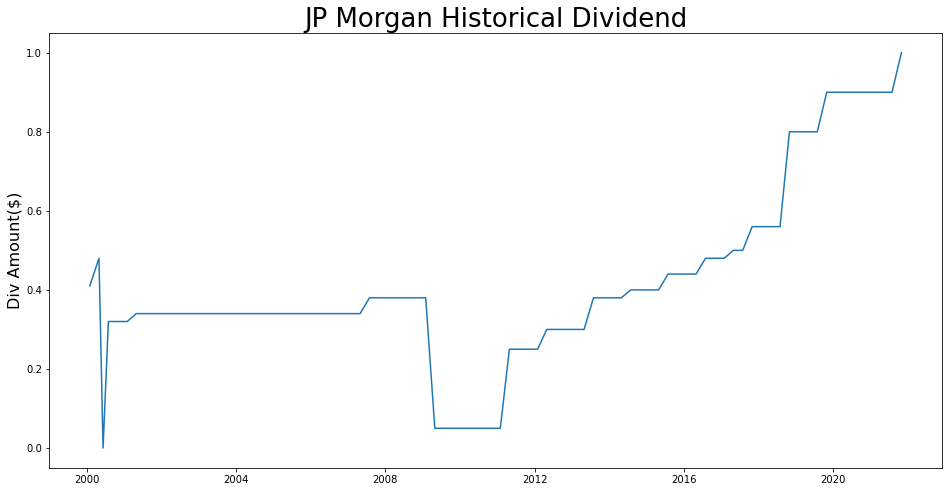

In [74]:
#Create Chart for Dividend amount
data_cht = dataraw.drop_duplicates(subset=['PayDate'], keep='last').copy()
data_cht = data_cht.sort_values(by='PayDate', ascending=True)
data_cht = data_cht.loc[:,["Date", "DeclarationDate", "PayDate", "RecDate", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()
plt.figure(figsize = (16,8))
plt.plot(data_cht["PayDate"], data_cht["DivAmount"])
plt.title("JP Morgan Historical Dividend",size=26)
plt.ylabel("Div Amount($)",size=16)
#plt.show()
plt.savefig('JPMorganHist.png')

In [36]:
#Separate dataset for return calculation
data_ret = dataraw.loc[:,["Date", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()
data_ret['RFR'] = data_ret['Date'].apply(lambda x: data_rfr[data_rfr['Date']>x]["RFR"].reset_index(drop=True)[0])/100


In [ ]:
datelist = np.sort(data_ret["Date"].unique())

def find_estimation_window(decl_date, diff):
    try:
        idx = np.where(datelist==decl_date)[0][0]
        return datelist[idx + diff]
    except:
        np.nan

dividend_meta.insert(1,'EstimationWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-125)))
dividend_meta.insert(2,'EstimationWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-11)))
dividend_meta.insert(3,'EventWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-10)))
dividend_meta.insert(4,'EventWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,10)))
dividend_meta.dropna(inplace = True)

In [38]:
datelist = np.sort(data_ret["Date"].unique())

def find_estimation_window(decl_date, diff):
    try:
        idx = np.where(datelist==decl_date)[0][0]
        return datelist[idx + diff]
    except:
        np.nan

dividend_meta = dataraw.drop_duplicates(subset=['DeclarationDate'], keep='last').reset_index(drop=True)[['DeclarationDate', 'DivAmount']].dropna().copy()
dividend_meta.insert(1,'EstimationWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-125)))
dividend_meta.insert(2,'EstimationWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-11)))
dividend_meta.insert(3,'EventWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-10)))
dividend_meta.insert(4,'EventWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,10)))
dividend_meta = dividend_meta.sort_values(by='DeclarationDate', ascending=True)
dividend_meta.dropna(inplace = True)

In [76]:
dividend_meta.tail(15)

,DeclarationDate,EstimationWindowSt,EstimationWindowEnd,EventWindowSt,EventWindowEnd,DivAmount
73,2018-03-20,2017-09-19,2018-03-05,2018-03-06,2018-04-04,0.56
74,2018-05-15,2017-11-13,2018-04-30,2018-05-01,2018-05-30,0.56
75,2018-09-18,2018-03-21,2018-08-31,2018-09-04,2018-10-02,0.80
76,2018-12-11,2018-06-13,2018-11-23,2018-11-26,2018-12-26,0.80
77,2019-03-19,2018-09-17,2019-03-04,2019-03-05,2019-04-02,0.80
78,2019-05-21,2018-11-16,2019-05-06,2019-05-07,2019-06-05,0.80
79,2019-09-17,2019-03-20,2019-08-30,2019-09-03,2019-10-01,0.90
80,2019-12-10,2019-06-13,2019-11-22,2019-11-25,2019-12-24,0.90
81,2020-03-17,2019-09-17,2020-03-02,2020-03-03,2020-03-31,0.90
82,2020-05-18,2019-11-15,2020-05-01,2020-05-04,2020-06-02,0.90


## Set Declaration date below

In [54]:
#Set index for lasvegas
#i = 33
#Set index for JPMorgan
i = 75

dec_date = dividend_meta['DeclarationDate'][i]
print(dec_date)

2018-09-18 00:00:00


In [55]:
est_st = dividend_meta['EstimationWindowSt'][i]
est_ed = dividend_meta['EstimationWindowEnd'][i]
evt_st = dividend_meta['EventWindowSt'][i]
evt_ed = dividend_meta['EventWindowEnd'][i]
data_est = data_ret[(data_ret['Date'] >= est_st) & (data_ret['Date'] <= est_ed)].reset_index(drop=True).copy()
data_evt = data_ret[(data_ret['Date'] >= evt_st) & (data_ret['Date'] <= evt_ed)].reset_index(drop=True).copy()

print('The mean return of the stock during estimation period is:', round(data_est['HolPerReturn'].mean()*100,3), '%')
print('The mean return of the market during estimation period is:', round(data_est['MarketReturn'].mean()*100,3), '%')
print("The standard deviation of the stock's return during estimation period is:", round(data_est['HolPerReturn'].std()*100,3), '%')
print("The standard deviation of the market's return during estimation period is:", round(data_est['MarketReturn'].std()*100,3), '%')


print('The mean return of the stock during event period is:', round(data_evt['HolPerReturn'].mean()*100,3), '%')
print('The mean return of the market during event period is:', round(data_evt['MarketReturn'].mean()*100,3), '%')
print("The standard deviation of the stock's return during event period is:", round(data_evt['HolPerReturn'].std()*100,3), '%')
print("The standard deviation of the market's return during event period is:", round(data_evt['MarketReturn'].std()*100,3), '%')


The mean return of the stock during estimation period is: 0.017 %
The mean return of the market during estimation period is: 0.065 %
The standard deviation of the stock's return during estimation period is: 1.334 %
The standard deviation of the market's return during estimation period is: 0.755 %
The mean return of the stock during event period is: -0.021 %
The mean return of the market during event period is: 0.0 %
The standard deviation of the stock's return during event period is: 0.949 %
The standard deviation of the market's return during event period is: 0.352 %


In [88]:
StkReturn = (data_est['HolPerReturn'] + 1).cumprod()
MarketReturn = (data_est['MarketReturn'] + 1).cumprod()

In [98]:
data_cht = pd.DataFrame(index = range(0,len(data_est)))
data_cht["JPM"] = StkReturn
data_cht["Market"] = MarketReturn
data_cht.index = data_est['Date']
data_cht

,JPM,Market
Date,,
2018-03-21,1.000872,1.000421
2018-03-22,0.959089,0.976496
2018-03-23,0.933444,0.957645
2018-03-26,0.962229,0.980873
2018-03-27,0.943562,0.964608
...,...,...
2018-08-27,1.028675,1.073387
2018-08-28,1.023651,1.073394
2018-08-29,1.020302,1.078957


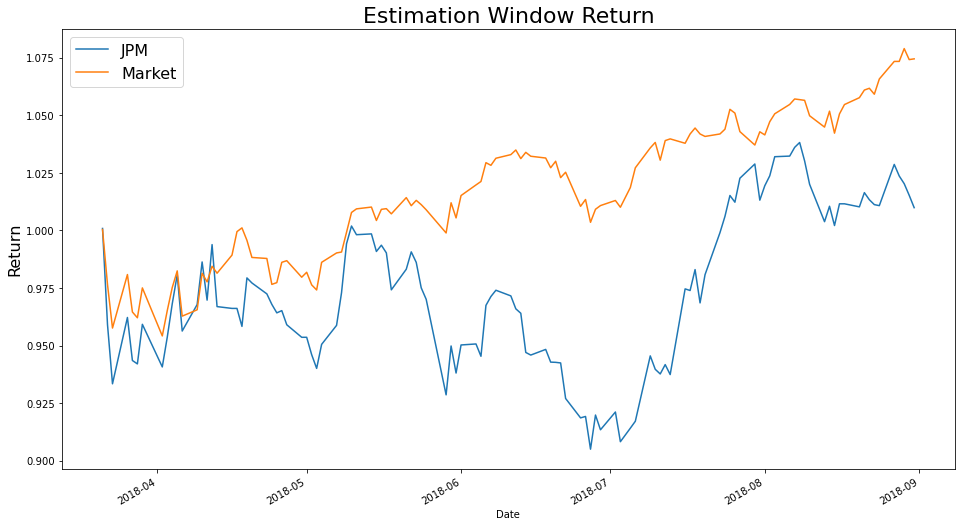

In [103]:
data_cht.plot(figsize = (16,9))
plt.title("Estimation Window Return",size=22)
plt.ylabel("Return",size=16)
plt.legend(loc=0, prop={'size': 16})
plt.show()

In [121]:
MarketReturn-1

0    -0.002248
1    -0.005742
2    -0.009686
3    -0.012034
4    -0.009788
5    -0.006589
6    -0.005766
7    -0.001467
8    -0.000564
9    -0.006536
10   -0.001078
11   -0.000554
12    0.007291
13    0.006241
14    0.002515
15    0.002004
16   -0.002028
17    0.000369
18    0.000459
19    0.002245
20   -0.000022
Name: MarketReturn, dtype: float64

In [112]:
StkReturn = (data_evt['HolPerReturn'] + 1).cumprod()
MarketReturn = (data_evt['MarketReturn'] + 1).cumprod()

In [113]:
data_cht = pd.DataFrame(index = range(0,len(data_evt)))
data_cht["JPM"] = StkReturn
data_cht["Market"] = MarketReturn
data_cht['Date'] = range(-10,11)
data_cht

,JPM,Market,Date
0,1.004975,0.997752,-10
1,1.000088,0.994258,-9
2,0.995811,0.990314,-8
3,0.997731,0.987966,-7
4,0.992407,0.990212,-6
5,0.998691,0.993411,-5
6,0.986909,0.994234,-4
7,0.990749,0.998533,-3
8,0.990575,0.999436,-2
9,0.993542,0.993464,-1


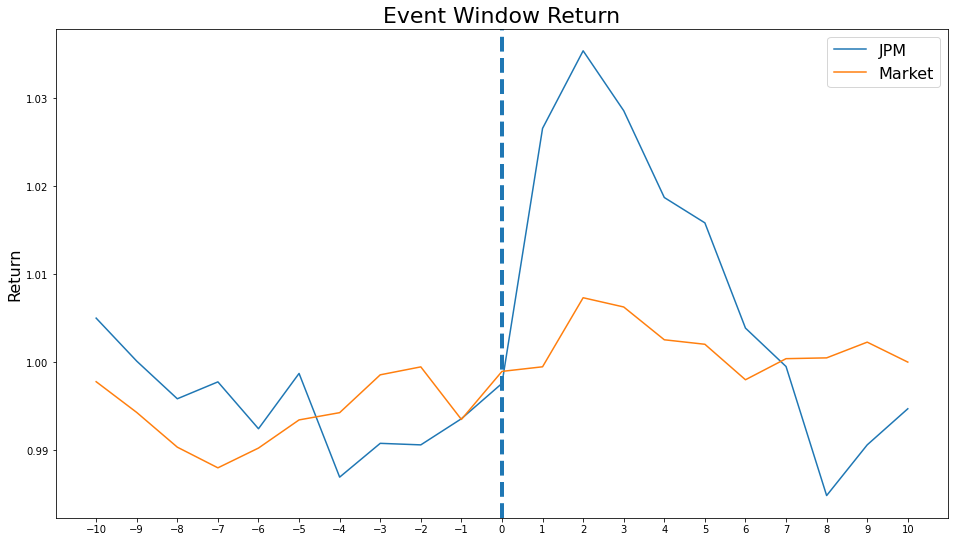

In [119]:
plt.figure(figsize = (16,9))
plt.plot(range(-10,11), data_cht[['JPM', 'Market']])
plt.axvline(0, linestyle = 'dashed', lw = 4)
plt.xticks(np.arange(-10, 11, 1.0))
plt.title("Event Window Return",size=22)
plt.ylabel("Return",size=16)
plt.legend(['JPM', 'Market'], loc=0, prop={'size': 16})
plt.show()

In [ ]:
plt.figure(figsize = (16,9))
#plt.plot(data_evt['Date'], data_evt['Price'])
plt.plot(range(-10,11), data_evt['Price'])
plt.show()

In [56]:
MktModel = sm.OLS(data_est["HolPerReturn"].astype(float), sm.add_constant(data_est['MarketReturn'].astype(float))).fit()
MktModel_alpha = MktModel.params[0]
MktModel_beta = MktModel.params[1]
MktModel_AR = data_evt["HolPerReturn"] - MktModel_alpha - MktModel_beta * data_evt["MarketReturn"]
MktModel_CAR = MktModel_AR.cumsum()

CAPMModel = sm.OLS(data_est["HolPerReturn"].astype(float) - data_est["RFR"].astype(float), 
                   sm.add_constant(data_est['MarketReturn'].astype(float) - data_est["RFR"].astype(float))).fit()
CAPMModel_beta = CAPMModel.params[0]
CAPMModel_AR = data_evt["HolPerReturn"] - data_evt["RFR"] - CAPMModel_beta * (data_evt['MarketReturn'] - data_evt["RFR"])
CAPMModel_CAR = CAPMModel_AR.cumsum()

MktAER_AR = data_evt["HolPerReturn"] - data_evt['MarketReturn']
MktAER_CAR = MktAER_AR.cumsum()

MeanAER_AR = data_evt["HolPerReturn"] - data_est['HolPerReturn'].mean()
MeanAER_CAR = MeanAER_AR.cumsum()

In [57]:
Mkt_SE = (data_est["HolPerReturn"] - MktModel_alpha - MktModel_beta * data_est["MarketReturn"]).std()
CAPM_SE = (data_est["HolPerReturn"] - data_est["RFR"] - CAPMModel_beta * (data_est['MarketReturn'] - data_est["RFR"])).std()
MAER_SE = (data_est["HolPerReturn"] - data_est['MarketReturn']).std()
MeAER_SE = (data_est["HolPerReturn"] - data_est['HolPerReturn'].mean()).std()

In [ ]:
Tstat_Table = pd.DataFrame()
Tstat_Table['Day'] = range(-10,11)
Tstat_Table['MarketModel'] = MktModel_AR/Mkt_SE
Tstat_Table['CAPMModel'] = CAPMModel_AR/CAPM_SE
Tstat_Table['MktAdjERModel'] = MktAER_AR/MAER_SE
Tstat_Table['MeanAdjERModel'] = MeanAER_AR/MeAER_SE
Tstat_Table.index = data_evt['Date']

PValue_Table = pd.DataFrame()
PValue_Table['Day'] = range(-10,11)
PValue_Table['MarketModel'] = 2 * stats.t.sf(abs(MktModel_AR/Mkt_SE), len(data_evt)-2)
PValue_Table['CAPMModel'] = 2 * stats.t.sf(abs(CAPMModel_AR/CAPM_SE), len(data_evt)-2)
PValue_Table['MktAdjERModel'] = 2 * stats.t.sf(abs(MktAER_AR/MAER_SE), len(data_evt)-1)
PValue_Table['MeanAdjERModel'] = 2 * stats.t.sf(abs(MeanAER_AR/MeAER_SE), len(data_evt)-1)
PValue_Table.index = data_evt['Date']

In [58]:
print(MktModel_alpha)
print(MktModel_beta)
print(CAPMModel_beta)

-0.0005993007624542847
1.1835767212627788
1.1787856138552875


In [59]:
AR_Table = pd.DataFrame()
AR_Table['Day'] = range(-10,11)
AR_Table['MarketModel'] = MktModel_AR
AR_Table['CAPMModel'] = CAPMModel_AR
AR_Table['MktAdjERModel'] = MktAER_AR
AR_Table['MeanAdjERModel'] = MeanAER_AR
AR_Table.index = data_evt['Date']

CAR_Table = pd.DataFrame()
CAR_Table['Day'] = range(-10,11)
CAR_Table['MarketModel'] = MktModel_CAR
CAR_Table['CAPMModel'] = CAPMModel_CAR
CAR_Table['MktAdjERModel'] = MktAER_CAR
CAR_Table['MeanAdjERModel'] = MeanAER_CAR
CAR_Table.index = data_evt['Date']

Tstat_Table = pd.DataFrame()
Tstat_Table['Day'] = range(-10,11)
Tstat_Table['MarketModel'] = MktModel_AR/Mkt_SE
Tstat_Table['CAPMModel'] = CAPMModel_AR/CAPM_SE
Tstat_Table['MktAdjERModel'] = MktAER_AR/MAER_SE
Tstat_Table['MeanAdjERModel'] = MeanAER_AR/MeAER_SE
Tstat_Table.index = data_evt['Date']

PValue_Table = pd.DataFrame()
PValue_Table['Day'] = range(-10,11)
PValue_Table['MarketModel'] = 2 * stats.t.sf(abs(MktModel_AR/Mkt_SE), len(data_evt)-2)
PValue_Table['CAPMModel'] = 2 * stats.t.sf(abs(CAPMModel_AR/CAPM_SE), len(data_evt)-2)
PValue_Table['MktAdjERModel'] = 2 * stats.t.sf(abs(MktAER_AR/MAER_SE), len(data_evt)-1)
PValue_Table['MeanAdjERModel'] = 2 * stats.t.sf(abs(MeanAER_AR/MeAER_SE), len(data_evt)-1)
PValue_Table.index = data_evt['Date']

### AR Table

In [60]:
AR_Table.to_csv (r'AR_Table.csv', index = True, header=True)
AR_Table

,Day,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
Date,,,,,
2018-09-04,-10,0.008235,0.012738,0.007223,0.004801
2018-09-05,-9,-0.000119,0.004378,-0.001361,-0.005037
2018-09-06,-8,0.001019,0.005514,-0.000309,-0.004450
2018-09-07,-7,0.005334,0.009836,0.004299,0.001754
2018-09-10,-6,-0.007428,-0.002903,-0.007610,-0.005510
2018-09-11,-5,0.003108,0.007638,0.003102,0.006158
2018-09-12,-4,-0.012180,-0.007662,-0.012627,-0.011972
2018-09-13,-3,-0.000627,0.003907,-0.000433,0.003717
2018-09-14,-2,-0.000647,0.003872,-0.001080,-0.000350


### CAR Table

In [61]:
CAR_Table.to_csv (r'CAR_Table.csv', index = True, header=True)
CAR_Table

,Day,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
Date,,,,,
2018-09-04,-10,0.008235,0.012738,0.007223,0.004801
2018-09-05,-9,0.008116,0.017117,0.005862,-0.000236
2018-09-06,-8,0.009135,0.022630,0.005553,-0.004686
2018-09-07,-7,0.014468,0.032466,0.009852,-0.002932
2018-09-10,-6,0.007040,0.029563,0.002242,-0.008442
2018-09-11,-5,0.010148,0.037201,0.005344,-0.002284
2018-09-12,-4,-0.002031,0.029539,-0.007283,-0.014256
2018-09-13,-3,-0.002659,0.033446,-0.007716,-0.010539
2018-09-14,-2,-0.003306,0.037318,-0.008796,-0.010889


### T-Stat Table

In [62]:
Tstat_Table.to_csv (r'Tstat_Table.csv', index = True, header=True)
Tstat_Table

,Day,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
Date,,,,,
2018-09-04,-10,0.831370,1.285243,0.722167,0.359859
2018-09-05,-9,-0.011995,0.441765,-0.136075,-0.377551
2018-09-06,-8,0.102829,0.556296,-0.030894,-0.333552
2018-09-07,-7,0.538455,0.992439,0.429821,0.131470
2018-09-10,-6,-0.749916,-0.292933,-0.760860,-0.413005
2018-09-11,-5,0.313806,0.770629,0.310143,0.461573
2018-09-12,-4,-1.229632,-0.773066,-1.262468,-0.897366
2018-09-13,-3,-0.063348,0.394224,-0.043292,0.278607
2018-09-14,-2,-0.065283,0.390637,-0.107980,-0.026236


### 5% SIgnificance

In [63]:
Sig5Table = PValue_Table.iloc[:,1:].apply(lambda x: np.where(x<0.05,"Significant", "Not Significant"))
Sig5Table.to_csv (r'Sig5Table.csv', index = True, header=True)
Sig5Table

,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
Date,,,,
2018-09-04,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-05,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-06,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-07,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-10,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-11,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-12,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-13,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-14,Not Significant,Not Significant,Not Significant,Not Significant


### 1% SIgnificance

In [64]:
Sig1Table = PValue_Table.iloc[:,1:].apply(lambda x: np.where(x<0.01,"Significant", "Not Significant"))
Sig1Table.to_csv (r'Sig1Table.csv', index = True, header=True)
Sig1Table

,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
Date,,,,
2018-09-04,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-05,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-06,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-07,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-10,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-11,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-12,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-13,Not Significant,Not Significant,Not Significant,Not Significant
2018-09-14,Not Significant,Not Significant,Not Significant,Not Significant


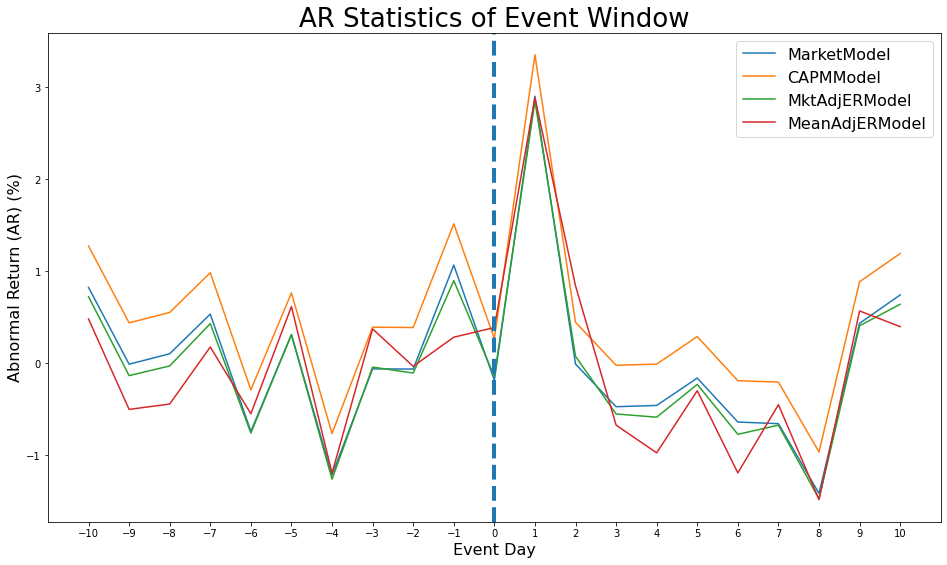

In [65]:
(AR_Table.set_index('Day')*100).plot(figsize = (16,9))
plt.axvline(0, linestyle = 'dashed', lw = 4)
plt.xticks(np.arange(-10, 11, 1.0))
plt.title("AR Statistics of Event Window",size=26)
plt.xlabel("Event Day",size=16)
plt.ylabel("Abnormal Return (AR) (%)",size=16)
plt.legend(loc=0, prop={'size': 16})
plt.show()

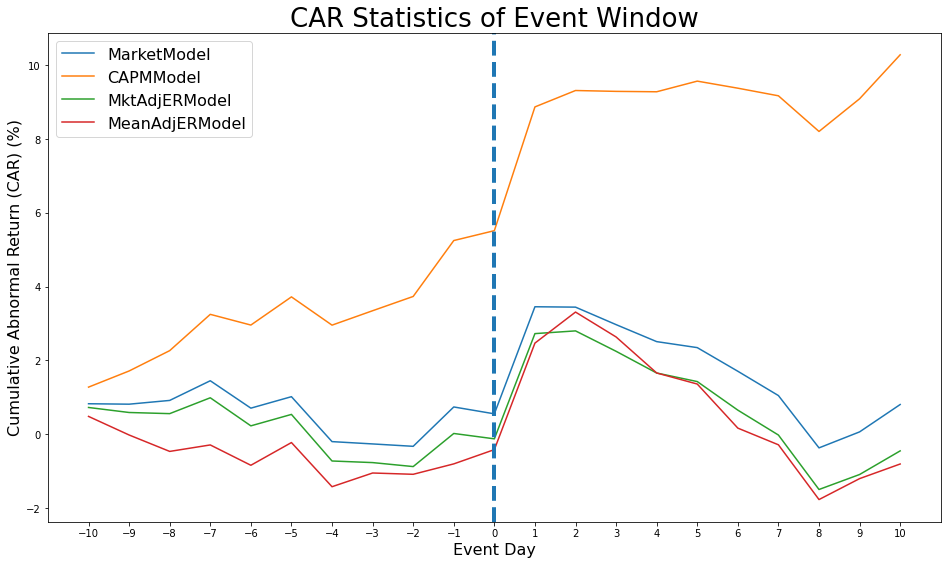

In [66]:
(CAR_Table.set_index('Day')*100).plot(figsize = (16,9))
plt.axvline(0, linestyle = 'dashed', lw = 4)
plt.xticks(np.arange(-10, 11, 1.0))
plt.title("CAR Statistics of Event Window",size=26)
plt.xlabel("Event Day",size=16)
plt.ylabel("Cumulative Abnormal Return (CAR) (%)",size=16)
plt.legend(loc=0, prop={'size': 16})
plt.show()

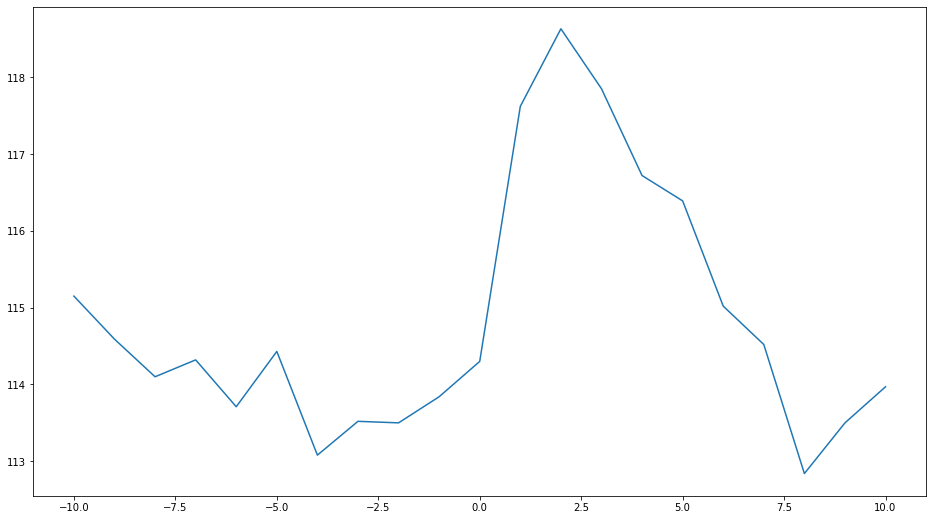

In [67]:
plt.figure(figsize = (16,9))
#plt.plot(data_evt['Date'], data_evt['Price'])
plt.plot(range(-10,11), data_evt['Price'])
plt.show()